# AMHE projekt
Kinga Hacaś,
Kinga Kwoka

## Środowisko

In [17]:
install.packages(c("stringr", "dplyr", "purrr", "ggplot2"))

Installing packages into ‘/home/kinga/R/x86_64-pc-linux-gnu-library/4.4’
(as ‘lib’ is unspecified)

also installing the dependencies ‘gtable’, ‘isoband’




In [18]:
source("des-classic.R") # load R implementation of DES
library("cec2017") # CEC interface for R
library("purrr")
library("ggplot2")

In [2]:
# Load nim implementation of DES
libPath = "libexample.so"
dyn.load(libPath)
des <- function(dimension, fn_i, maxGenerations) {
  return(.Call("des", dimension, fn_i, maxGenerations))
}

In [3]:
#Set random seed
set.seed(47)

## Eksperymenty

### Parametry eksperymentów

In [112]:
param_function_id <- c(3, 7, 9, 15, 30) #, 15, 30) #functions 10+ are not defined for 2 dimensions
param_dimensions <- c(2, 10)
repeat_experiment <- 2

param_combinations <- expand.grid(fn_i=param_function_id, dimensions=param_dimensions)
param_combinations <- subset(param_combinations, !(dimensions == 2 & fn_i > 10))

In [114]:
run_experiment <- function(fn_i, dim) {
  results <- list(R=vector("list", length = repeat_experiment), nim=vector("list", length = repeat_experiment))
  params <- list(fn_i, dim)
  times <- list(R=numeric(repeat_experiment),nim=numeric(repeat_experiment))

  maxit <- round(10000 * dim / (4 * dim + 1))
  for (j in 1:repeat_experiment) {
    #R implementation
    start_time <- Sys.time()
    result <- des_classic(rep(0, dim), fn = partial(cec2017, i = fn_i))
    end_time <- Sys.time()
    elapsed_time <- end_time - start_time

    results[["R"]][[j]] <- list(value=result$value, convergence=result$convergence, par=result$par)# iters=length(result$diagnostic$Ft))
    times[["R"]][j] <- as.numeric(elapsed_time, units="secs")

    #nim implementation
    start_time <- Sys.time()
    result <- des(dimension = dim, fn_i = fn_i, maxGenerations = maxit)
    end_time <- Sys.time()
    elapsed_time <- end_time - start_time

    results[["nim"]][[j]] <- list(value=cec2017(fn_i, result), par=result)
    times[["nim"]][j] <- as.numeric(elapsed_time, units="secs")
  }

  return(list(params = params, results = results, times = times))
}

In [115]:
results <- apply(param_combinations, 1, function(x) {
  run_experiment(x[1], x[2])
})

In [116]:
plot_data <- data.frame(
  fn_i = integer(),
  dimensions = integer(),
  method = character(),
  value = numeric(),
  time = numeric(),
  stringsAsFactors = FALSE
)

In [117]:
for (entry in results) {
  fn_i <- entry$params[[1]]
  dimensions <- entry$params[[2]]

  R_value <- unlist(lapply(entry$results$R, function(x) x$value))
  nim_value <- unlist(lapply(entry$results$nim, function(x) x$value))
  R_time <- entry$times$R
  nim_time <- entry$times$nim

  plot_data <- rbind(plot_data,
                     data.frame(fn_i = fn_i,
                                dimensions = dimensions,
                                method = "R",
                                value = R_value,
                                time = R_time),
                     data.frame(fn_i = fn_i,
                                dimensions = dimensions,
                                method = "nim",
                                value = nim_value,
                                time = nim_time))
}

Warning message in data.frame(fn_i = fn_i, dimensions = dimensions, method = "R", :
“row names were found from a short variable and have been discarded”
Warning message in data.frame(fn_i = fn_i, dimensions = dimensions, method = "nim", :
“row names were found from a short variable and have been discarded”
Warning message in data.frame(fn_i = fn_i, dimensions = dimensions, method = "R", :
“row names were found from a short variable and have been discarded”
Warning message in data.frame(fn_i = fn_i, dimensions = dimensions, method = "nim", :
“row names were found from a short variable and have been discarded”
Warning message in data.frame(fn_i = fn_i, dimensions = dimensions, method = "R", :
“row names were found from a short variable and have been discarded”
Warning message in data.frame(fn_i = fn_i, dimensions = dimensions, method = "nim", :
“row names were found from a short variable and have been discarded”
Warning message in data.frame(fn_i = fn_i, dimensions = dimensions, method =

In [139]:
# Plot 1: Boxplot of value for R and nim
l <- labeller(
  dimensions = c("2" = "N = 2", "10" = "N = 10"),
  fn_i = c("2" = "F2", "7" = "F7","9" = "F9","15" = "F15","30" = "F30"))
p1 <- ggplot(plot_data, aes(x = method, y = value)) +
  geom_boxplot() +
  facet_wrap(fn_i ~ dimensions, scales = "free", ncol=4, labeller = l) +
  labs(title = "Resulting values for R and nim implementations",
       x = "Method",
       y = "Value")

# Plot 2: Boxplot of times for R and nim
p2 <- ggplot(plot_data, aes(x = method, y = time)) +
  geom_boxplot() +
  facet_wrap(fn_i ~ dimensions, scales = "free", ncol=4, labeller = l) +
  labs(title = "Execution times for R and nim implementations",
       x = "Method",
       y = "Time")

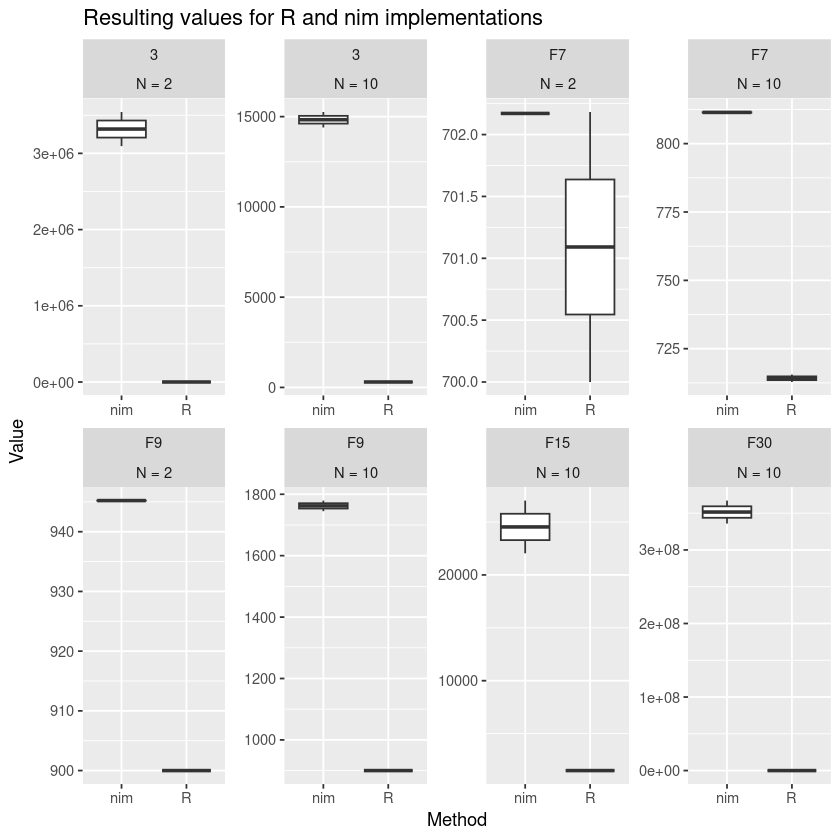

In [143]:
ggsave(p1, filename = "results/value_boxplot.png", height=5, width=10)
p1

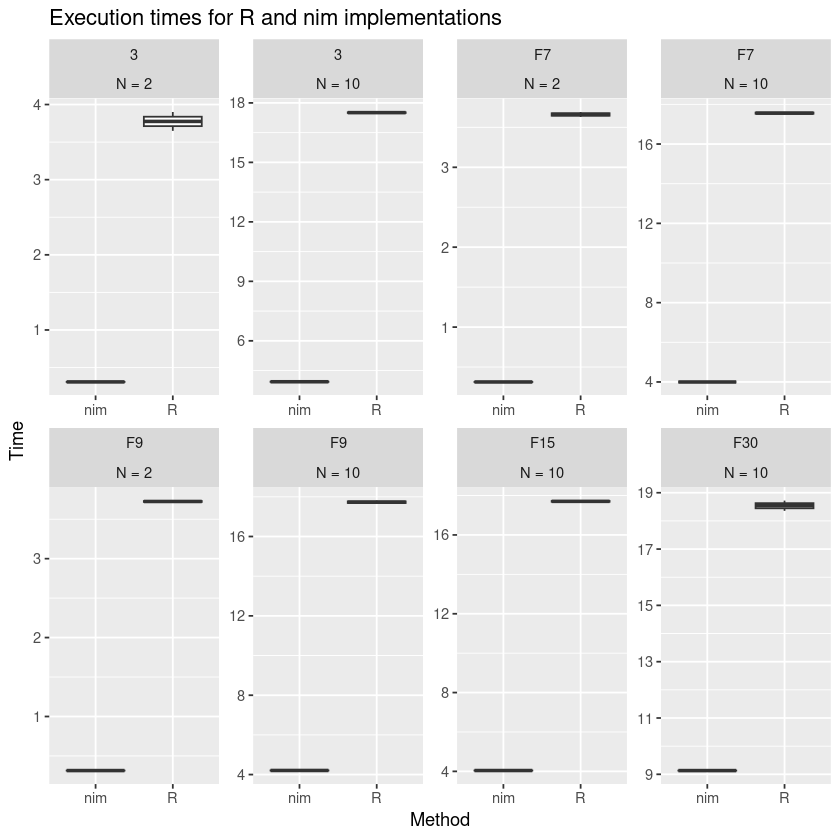

In [144]:
ggsave(p2, filename = "results/time_boxplot.png", height=5, width=10)
p2